In [35]:
from langgraph.graph import Graph
from pydantic import BaseModel
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
from langchain_community.tools import TavilySearchResults
from typing import TypedDict
from langgraph.graph import END, START, StateGraph, MessagesState
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from typing import Union

from fastapi import FastAPI
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
llm=ChatGroq(model="llama3-groq-70b-8192-tool-use-preview")


In [36]:
class InputState(TypedDict):
    user_question:str
    user_answer:str
    gen_context:str
    question_type:str
class OutputState(TypedDict):
    feedback:str
    marks:int
    factual_accuracy: int
    completeness: int
    errors:int
    percentage:float
class OverallState(InputState,OutputState):
    pass


In [37]:
tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
    
)
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [38]:
import datetime

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig, chain

today = datetime.datetime.today().strftime("%D")
prompt = ChatPromptTemplate(
    [
        ("system", f"You are a helpful assistant. The date today is {today}."),
        ("human", "{user_input}"),
        ("placeholder", "{messages}"),
    ]
)

llm_with_tools = llm.bind_tools([tool,wikipedia])

llm_chain = prompt | llm_with_tools


@chain
def tool_chain(state:InputState):
    user_input=state["user_question"]
    input_ = {"user_input": user_input}
    ai_msg = llm_chain.invoke(input_)
    print("ai_msg",ai_msg)
    tool_msgs = tool.batch(ai_msg.tool_calls)
    print("tool_msgs",tool_msgs)
    z=llm_chain.invoke({**input_, "messages": [ai_msg, *tool_msgs]})
    print("toolchain",z)
    return {"gen_context":z}




In [39]:
def parse_llm_response(response):
    # Parse each section of the response
    # Example output from LLM assumed to be structured JSON-like
    return {
        "factual_accuracy": response["Factual Accuracy"],
        "completeness": response["Completeness"],
        "clarity": response["Clarity"],
        "structure": response["Structure"],
        "total_score": response["Total Score"],
        "feedback": response["Justifications"]
    }

class EvaluationOutput(BaseModel):
    factual_accuracy: int
    completeness: int
    total_score: int
    justification: str
    errors:int
    percentage:float
    



In [40]:
def evaluate(state: InputState):
    """Evaluate the question and answer using the generated context."""
    prompt = f"""
You are an expert educator, renowned for your ability to evaluate answers across various subjects with precision, fairness, and depth. Your task is to assess the user's answer based on the provided question, reference answer (if available), and the specific requirements of the subject.

### Information for Evaluation:
- **Reference Answer**: "{state['gen_context']}" (if provided; otherwise, base your evaluation on the question and subject knowledge)
- **User's Answer**: "{state['user_answer']}"
- **Question**: "{state['user_question']}"
- **Question Type**: "{state['question_type']}"

### Evaluation Guidelines:
1. **Understand the Question**:
   - Analyze the question carefully to determine its key requirements, such as concepts, steps, grammar, or factual accuracy.
2. **Evaluate the User's Answer Based on Subject**:
   - **English**: Check for correct grammar, sentence structure, vocabulary usage, and whether the answer aligns with the question's intent.
   - **Mathematics**: Evaluate the answer step-by-step, ensuring calculations, formulas, and logic are accurate, and verify the final answer.
   - **General Knowledge**: Verify the correctness and relevance of the answer against factual information.
   - **Other Subjects**: Ensure the answer demonstrates understanding of the subject, relevance to the question, and correctness of concepts or facts.

3. **Apply the Scoring Criteria**:
   - **Factual Accuracy**: Score between 1-10 based on correctness and precision of the answer.
   - **Completeness**: Score between 1-10 based on how well the answer addresses all parts of the question.
   - **Errors**: Deduct points (up to 10) for mistakes, irrelevant information, or gaps in logic, grammar, or steps.
   - **Bonus for Excellence**: (Optional) Add bonus points for exceptional depth, creativity, or clarity, while staying within the total score limit.

4. **Calculate Total Score and Percentage**:
   - The maximum total score is **40**.
   - Convert the total score into a percentage: `(total_score / 40) * 100`.

5. **Special Case**:
   - If the answer does not address the question or is entirely irrelevant, assign a **total score** of 0 and a **percentage** of 0%.

### Scoring Output:
Provide your evaluation in the following structured JSON format:
```json
{{
    "factual_accuracy": (integer between 1-10),
    "completeness": (integer between 1-10),
    "errors": (integer between 1-10),
    "total_score": (integer between 0-40),
    "percentage": (float rounded to two decimal places),
    "justification": "A detailed explanation of the evaluation, tailored to the subject, highlighting strengths, weaknesses, and the reasoning behind the scores."
}}

    
    # prompt = f"""
    # Here is a reference answer: "{state["gen_context"]}"
    # Here is the user’s answer: "{state["user_answer"]}"
    # Here is the question: "{state["user_question"]}"
    # You are a highly skilled evaluator and check if the user answer is correct as per the question give full marks otherwise. Evaluate the user's answer using the following criteria:
    # - Factual Accuracy: Rate from 1-10.
    # - Completeness: Rate from 1-10.
    # Provide the following structured output:
    # {{
    #     "factual_accuracy": (integer between 1-10),
    #     "completeness": (integer between 1-10),
    #     "total_score": (integer between 0-30),
    #     "justification": (string)
    # }}
    # Ensure your response strictly adheres to this JSON format.
    # """
    response = llm.invoke(prompt)
    try:
        parsed_response = EvaluationOutput.parse_raw(response.content)
        return {
            "marks": parsed_response.total_score,
            "feedback": parsed_response.justification,
            "factual_accuracy":parsed_response.factual_accuracy,
            "completeness":parsed_response.completeness,
            "errors":parsed_response.errors,
            "percentage":parsed_response.percentage

        }
    except Exception as e:
        print("Error parsing response:", e)
        return {
            "marks": 0,
            "feedback": "Unable to parse response. Please ensure the format is correct.",
        }


In [41]:
builder=StateGraph(OverallState, input=InputState, output=OutputState)
builder.add_node("tailvy_tool",tool_chain)
builder.add_node("evalulate",evaluate)
builder.add_edge(START,"tailvy_tool")
builder.add_edge("tailvy_tool","evalulate")
builder.add_edge("evalulate",END)
graph=builder.compile()


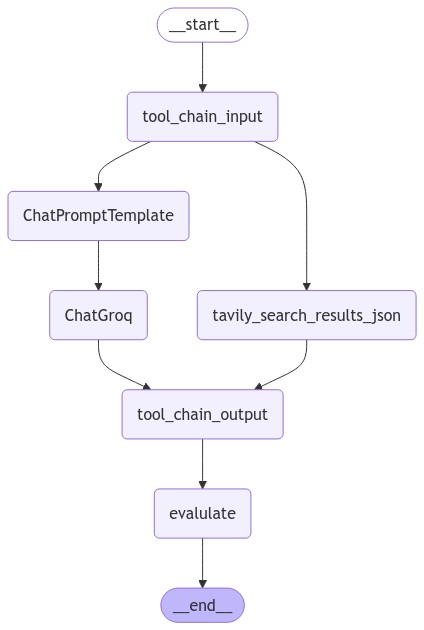

In [42]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [43]:
data=graph.invoke({"user_question":"who is the founder of apple company?","user_answer":"steve jobs ","gen_context:str":"None","question_type":"Short"})

ai_msg content='' additional_kwargs={'tool_calls': [{'id': 'call_f1cz', 'function': {'arguments': '{"query": "Apple Inc."}', 'name': 'wikipedia'}, 'type': 'function'}, {'id': 'call_cmfy', 'function': {'arguments': '{"query": "Apple Inc. founder"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 356, 'total_tokens': 417, 'completion_time': 0.194035952, 'prompt_time': 0.025959501, 'queue_time': 0.008071636000000004, 'total_time': 0.219995453}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-fdf2a83b-4deb-4421-981f-16174dfd979d-0' tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Apple Inc.'}, 'id': 'call_f1cz', 'type': 'tool_call'}, {'name': 'tavily_search_results_json', 'args': {'query': 'Apple Inc. founder'}, 'id': 'call_cmfy', 'type': 'tool_call'}] usage_metadata={'input_tokens': 356, 'outpu

In [44]:
data

{'feedback': "The user's answer is partially correct, as it identifies Steve Jobs as one of the founders of Apple Inc. However, it lacks completeness, as it does not mention Steve Wozniak, the other co-founder. Additionally, the answer has some factual accuracy issues, as it does not specify the year of the company's founding. Errors in the answer include the lack of detail and missing information.",
 'marks': 8,
 'factual_accuracy': 7,
 'completeness': 3,
 'errors': 2,
 'percentage': 20.0}

In [45]:
import nest_asyncio
import uvicorn
import subprocess
from fastapi.responses import JSONResponse
from fastapi import FastAPI, HTTPException, status


In [ ]:

app = FastAPI()
class Item(BaseModel):
    user_question: str
    user_answer: str
    question_type: str =None

@app.post("/evaluate")
def evaluate(item: Item):
    data=graph.invoke({"user_question":item.user_question,"user_answer":item.user_answer,"gen_context:str":"None","question_type":item.question_type})
    # feedback=data["feedback"]
    # marks=data["marks"]
    # factual_accuracy=data["factual_accuracy"]
    # completeness=data["completeness"]
    # errors=data["errors"]
    # percentage=data["percentage"]
    return JSONResponse(
        content={"message": "Item created successfully", "data": data},
        status_code=status.HTTP_201_CREATED  # HTTP 201 Created
    )

In [47]:


class Item(BaseModel):
    name: str
    description: str
    price: float
    tax: float = None

@app.post("/create_item")
def create_item(item: Item):
    # Example of using the status code for 'Created' (201)
    print(item.name)
    return JSONResponse(
        content={"message": "Item created successfully", "item": item.dict(),"name":item.name},
        status_code=status.HTTP_201_CREATED  # HTTP 201 Created
    )

In [48]:
import asyncio
import uvicorn

async def serve():
    config = uvicorn.Config(app, host="127.0.0.1", port=8001)
    server = uvicorn.Server(config)
    await server.serve()

asyncio.run(serve())

INFO:     Started server process [25460]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8001 (Press CTRL+C to quit)


INFO:     127.0.0.1:54470 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:54470 - "GET /openapi.json HTTP/1.1" 200 OK
ai_msg content='' additional_kwargs={'tool_calls': [{'id': 'call_qvx3', 'function': {'arguments': '{"query": "Shahrukh Khan"}', 'name': 'wikipedia'}, 'type': 'function'}, {'id': 'call_83ax', 'function': {'arguments': '{"query": "Shahrukh Khan"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 357, 'total_tokens': 421, 'completion_time': 0.202879519, 'prompt_time': 0.026176992, 'queue_time': 0.008015195, 'total_time': 0.229056511}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-09f4bbd7-d6d5-45d2-b807-5a51508acfbb-0' tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Shahrukh Khan'}, 'id': 'call_qvx3', 'type': 'tool_call'}, {'name': 'tavily_search_results_json', 'args': {'que

ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "d:\evaluator api\myenv\Lib\site-packages\uvicorn\protocols\http\httptools_impl.py", line 401, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\evaluator api\myenv\Lib\site-packages\uvicorn\middleware\proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\evaluator api\myenv\Lib\site-packages\fastapi\applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "d:\evaluator api\myenv\Lib\site-packages\starlette\applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "d:\evaluator api\myenv\Lib\site-packages\starlette\middleware\errors.py", line 187, in __call__
    raise exc
  File "d:\evaluator api\myenv\Lib\site-packages\starlette\middleware

KeyboardInterrupt: 